In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_curve, auc, precision_recall_curve, 
                             confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, 
                             classification_report, recall_score, balanced_accuracy_score, f1_score, precision_score)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Normalization, StringLookup

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\wine.csv")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [3]:
x = df.drop(columns=['Customer_Segment']).values
y = df['Customer_Segment'].values

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify =y)

In [ ]:
lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
lookup.adapt(y_train)
y_train_adapt = lookup(y_train)
y_test_adapt =lookup(y_test)

In [ ]:
normalizer = Normalization(axis=-1)
normalizer.adapt(x_train)
x_train_adapt = normalizer(x_train)
x_test_adapt = normalizer(x_test)

In [6]:
y_train = y_train - 1
y_test = y_test - 1

In [7]:
class_weights = dict(enumerate(
    compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
))

In [ ]:
def build_model(hp):
    normalizer = layers.Normalization(axis=-1)
    normalizer.adapt(x_train)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape = (x_train.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'units_{i}',
                                                     min_value = 16, max_value = 128, step = 8),
                                                     activation=hp.Choice('activation',['relu','tanh']),
                                                     kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-3, sampling='log'))
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f'dropout_rate_{i}',
                                                         min_value=0.1, max_value=0.3, step=0.1)))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice(
                'lr',[0.01, 0.001])), loss='sparse_categorical_crossentropy',metrics=[
                    'accuracy'])
    return model

In [12]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials = 3,
    directory = 'keras_tuner_results',
    project_name='wine_mlpc'
    )

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
    )

In [ ]:
tuner.search(x_train, y_train,
             validation_split=0.2, epochs = 10,
             batch_size = 16, verbose=1)

Trial 3 Complete [00h 00m 14s]
val_loss: 0.14847742021083832

Best val_loss So Far: 0.02706369198858738
Total elapsed time: 00h 00m 59s


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
history = best_model.fit(x_train, y_train,
                         validation_split=0.2,
                         epochs=20,
                         batch_size=16,
                         class_weight=class_weights,
                         verbose=True)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.3582 - loss: 1.4717 - val_accuracy: 1.0000 - val_loss: 0.3920
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8964 - loss: 0.3016 - val_accuracy: 1.0000 - val_loss: 0.1497
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9509 - loss: 0.1539 - val_accuracy: 1.0000 - val_loss: 0.0886
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9421 - loss: 0.1526 - val_accuracy: 1.0000 - val_loss: 0.0701
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9311 - loss: 0.1864 - val_accuracy: 1.0000 - val_loss: 0.0578
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9725 - loss: 0.0711 - val_accuracy: 1.0000 - val_loss: 0.0447
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9812 - loss: 0.0706 - val_accuracy: 1.0000 - val_loss: 0.0399
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9747 - loss: 0.0596 - val_accuracy: 1.0000 - val_loss: 0.0292

In [ ]:
y_predict = best_model.predict(x_test)
y_pred = np.argmax(y_predict, axis = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step


In [18]:
print(y_predict)
print(y_pred)

[[9.9993587e-01 7.9697766e-06 5.6154146e-05]
 [6.6577160e-04 4.3559638e-01 5.6373781e-01]
 [9.9975449e-01 1.9581651e-04 4.9642316e-05]
 [2.8981227e-01 7.0715117e-01 3.0364951e-03]
 [4.4457819e-03 9.9499303e-01 5.6118990e-04]
 [9.9993289e-01 6.9397902e-06 6.0230239e-05]
 [9.9972826e-01 3.0667334e-06 2.6861718e-04]
 [2.5268186e-02 9.7470564e-01 2.6233116e-05]
 [1.1759301e-03 9.8939764e-01 9.4264308e-03]
 [6.2697660e-04 8.4623589e-06 9.9936455e-01]
 [2.5842900e-03 9.9674690e-01 6.6878705e-04]
 [3.1193702e-02 2.3094831e-02 9.4571143e-01]
 [9.9991596e-01 3.1302352e-06 8.0982463e-05]
 [8.2821976e-03 5.9779131e-01 3.9392650e-01]
 [9.9994266e-01 2.5117060e-06 5.4786473e-05]
 [2.6001711e-05 9.9996579e-01 8.2425449e-06]
 [2.2890759e-05 9.9989307e-01 8.4071209e-05]
 [9.9939799e-01 5.6056672e-04 4.1418501e-05]
 [3.4914320e-04 9.9962556e-01 2.5318950e-05]
 [9.4780713e-01 5.1770449e-02 4.2239184e-04]
 [2.8119652e-04 9.9970990e-01 8.8445331e-06]
 [1.4811427e-04 9.9962175e-01 2.3014497e-04]
 [9.998315

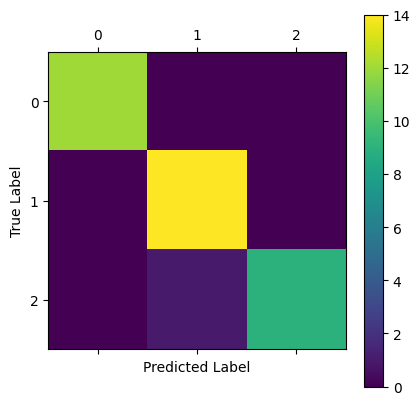

In [19]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9722222222222222

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



Text(113.9222222222222, 0.5, 'true value')

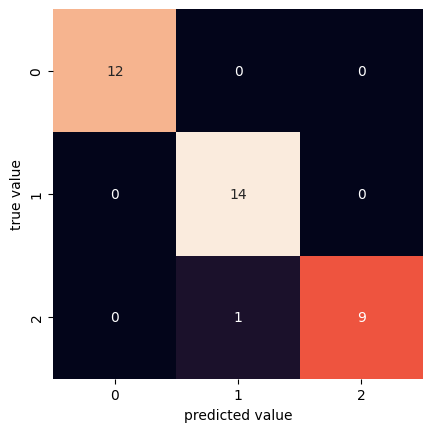

In [21]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0.9966780904280904


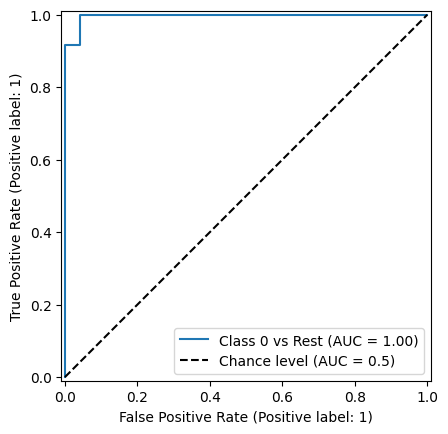

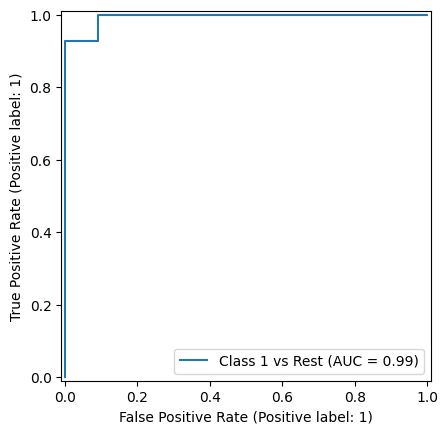

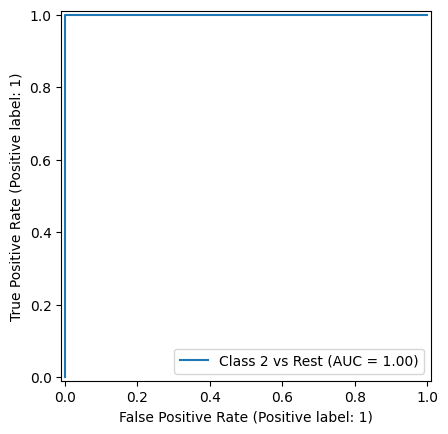

In [166]:
y_prob = best_model.predict(x_test_adapt)

roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(roc_auc_ovr)
classes = np.unique(y_test)

y_test_bin = label_binarize(y_test, classes = classes)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

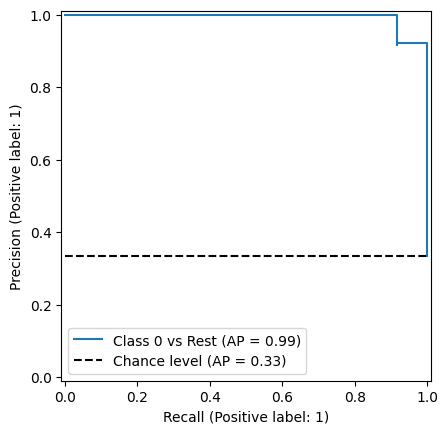

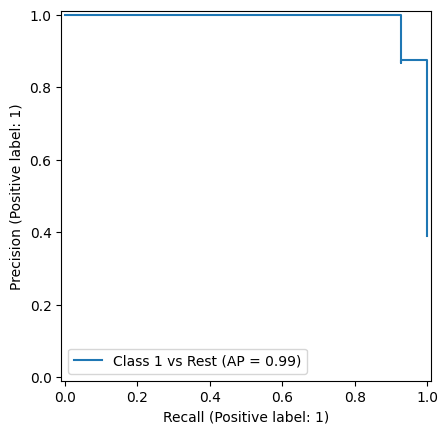

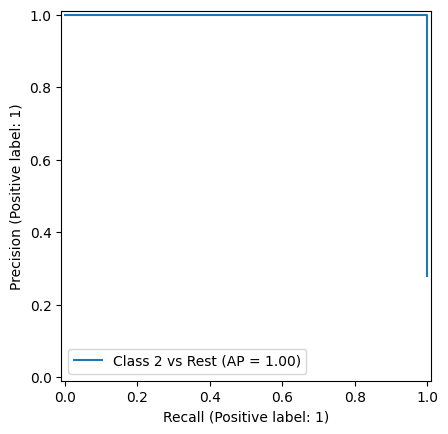

In [167]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

In [ ]:
print("\nModel Evaluation:")
results = best_model.evaluate(x_test_adapt, y_test, verbose=0)
metrics = dict(zip(best_model.metrics_names, results))
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Model Evaluation:
loss: 0.0911
compile_metrics: 0.9444


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


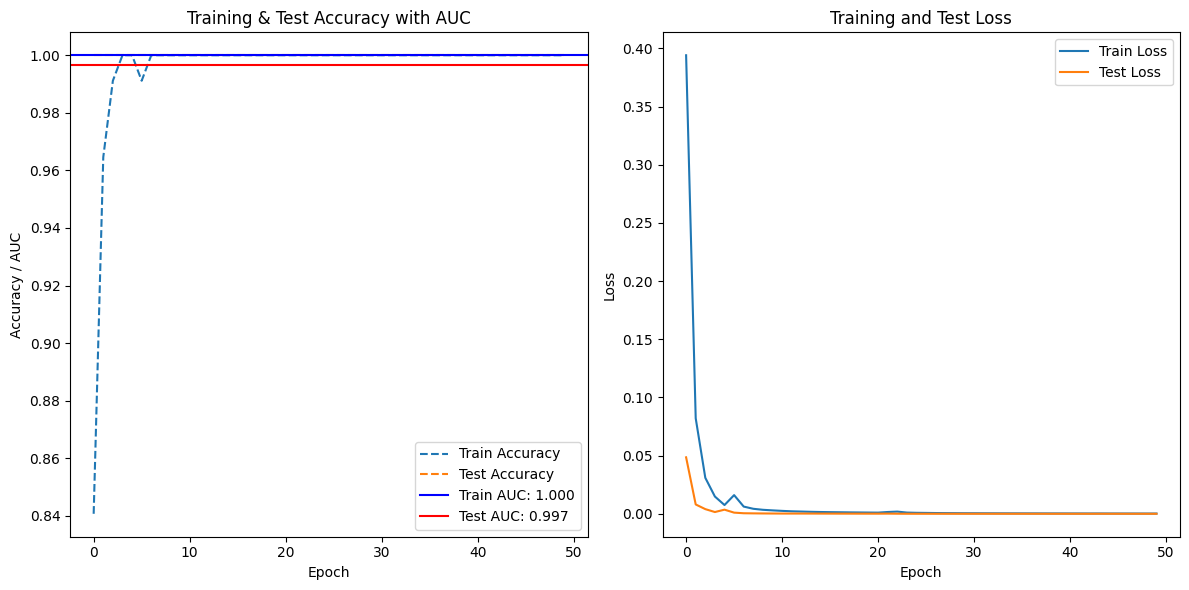

In [176]:
y_train_pred = best_model.predict(x_train_adapt)
y_test_pred = best_model.predict(x_test_adapt)

if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train_true = np.argmax(y_train, axis=1)
    y_test_true = np.argmax(y_test, axis=1)
    y_train_pred = np.max(y_train_pred, axis=1)  
    y_test_pred = np.max(y_test_pred, axis=1)
else:
    y_train_true = y_train.ravel() 
    y_test_true = y_test.ravel()

train_auc = roc_auc_score(y_train_true, y_train_pred, multi_class='ovr')
test_auc = roc_auc_score(y_test_true, y_test_pred, multi_class='ovr')

train_loss = history.history['loss']
test_loss = history.history['val_loss'] 
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', linestyle='dashed')
plt.plot(test_acc, label='Test Accuracy', linestyle='dashed')
plt.axhline(train_auc, color='blue', linestyle='solid', label=f'Train AUC: {train_auc:.3f}')
plt.axhline(test_auc, color='red', linestyle='solid', label=f'Test AUC: {test_auc:.3f}')
plt.title('Training & Test Accuracy with AUC')
plt.ylabel('Accuracy / AUC')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [170]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\nAdvanced Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Advanced Metrics:
Precision: 0.9505
Recall (Sensitivity): 0.9429
F1 Score: 0.9453
Balanced Accuracy: 0.9429


In [ ]:
print("\nAdvanced Metrics:")
print(f"- Maximum Training Accuracy: {max(train_acc):.4f}")
print(f"- Minimum Test Loss: {min(test_loss):.4f}")
print(f"- Optimal Epochs: {len(train_loss)}")
print(f"- Maximum Training AUC: {train_auc:.4f}")
print(f"- Test AUC: {test_auc:.4f}")


Advanced Metrics:
- Maximum Training Accuracy: 1.0000
- Minimum Test Loss: 0.0000
- Optimal Epochs: 50
- Maximum Training AUC: 1.0000
- Test AUC: 0.9967


Feature 0: 0.1552121639251709
Feature 1: 0.10906735807657242
Feature 2: 0.14630922675132751
Feature 3: 0.13181143999099731
Feature 4: 0.0985739454627037
Feature 5: 0.11360431462526321
Feature 6: 0.13929247856140137
Feature 7: 0.09187333285808563
Feature 8: 0.12142744660377502
Feature 9: 0.2042396366596222
Feature 10: 0.157963365316391
Feature 11: 0.12449564039707184
Feature 12: 0.17856261134147644


C:\Users\Robyi\AppData\Local\Temp\ipykernel_11792\1966358113.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")


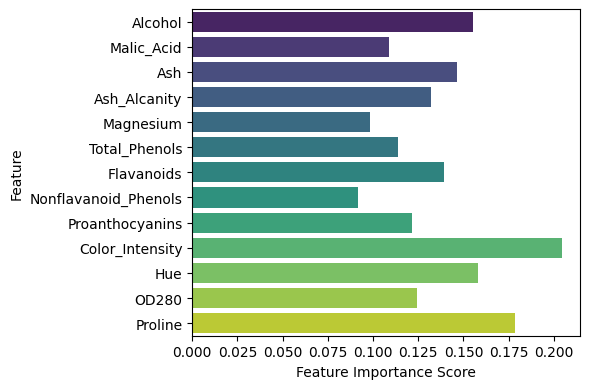

In [172]:
weights = best_model.layers[0].get_weights()[0]

feature_importance = np.mean(np.abs(weights), axis=1)
column = df.drop(columns=['Customer_Segment'])
feature_names = column.columns

for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: {importance}")

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [112]:
best_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 88)             │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,499 (17.58 KB)

 Trainable params: 1,499 (5.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,000 (11.72 KB)

In [124]:
explainer = shap.Explainer(best_model, x_train)

if hasattr(x_test_adapt, 'numpy'):
    x_test_adapt = x_test_adapt.numpy()
shap_values = explainer(x_test_adapt)

PermutationExplainer explainer: 37it [00:10,  2.13s/it]                        


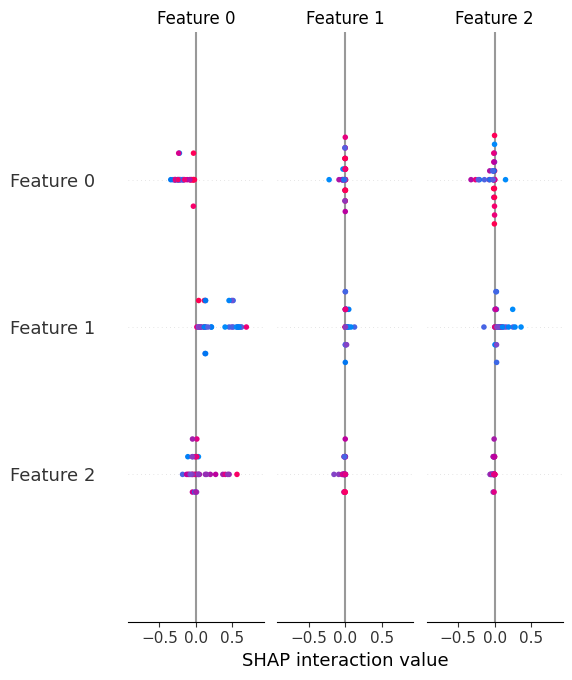

In [127]:
shap.summary_plot(shap_values.values, x_test_adapt)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\winepredict.csv")
prediksi.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
2,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
3,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
4,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045


In [145]:
probabilitas_prediksi = best_model.predict(prediksi.values)
y_prediksi = np.argmax(probabilitas_prediksi, axis =1)
print(probabilitas_prediksi)
print(y_prediksi)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
[[9.9990237e-01 8.3253044e-13 9.7587639e-05]
 [9.9990237e-01 8.3253044e-13 9.7587639e-05]
 [9.9990237e-01 8.3253359e-13 9.7589036e-05]
 [9.9990237e-01 8.3253044e-13 9.7587639e-05]
 [9.9990237e-01 8.3253044e-13 9.7587639e-05]
 [9.9990237e-01 8.3253044e-13 9.7587639e-05]
 [9.9990237e-01 8.3261300e-13 9.7610631e-05]]
[0 0 0 0 0 0 0]
